In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

In [4]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [5]:
import visual_behavior.data_access.loading as loading
import visual_behavior.visualization.utils as utils

from visual_behavior.ophys.response_analysis.response_analysis import ResponseAnalysis

C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.4) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


### get experiments table and example dataset

In [6]:
ophys_experiment_table = loading.get_filtered_ophys_experiment_table(release_data_only=True)

ophys_experiment_ids = ophys_experiment_table.index.values

In [7]:
ophys_experiment_id = ophys_experiment_table.index[100]
ophys_session_id = ophys_experiment_table.loc[ophys_experiment_id].ophys_session_id
dataset = loading.get_ophys_dataset(ophys_experiment_id, from_lims=False, from_nwb=False)

In [8]:
analysis = ResponseAnalysis(dataset, use_extended_stimulus_presentations=True)

In [9]:
# sdf = analysis.get_response_df(df_name='stimulus_response_df')

### load cell metrics table for a set of conditions

In [10]:
import visual_behavior.ophys.response_analysis.cell_metrics as cell_metrics

In [11]:
%%time

condition = 'changes' # can be 'changes', 'omissions', 'images', or 'traces'
session_subset = 'engaged' # can be 'engaged', 'disengaged', or 'full_session'
stimulus = 'pref_image' # can be 'all_images', 'pref_image'
use_events = False # True for events, False for dF/F

ophys_experiment_ids = ophys_experiment_table.index.values

metrics_df = cell_metrics.load_cell_metrics_table_for_experiments(ophys_experiment_ids, condition, stimulus, session_subset, use_events)

# remove novel session retakes
metrics_df = loading.remove_first_novel_session_retakes_from_df(metrics_df)


c:\users\marinag\documents\code\visual_behavior_analysis\visual_behavior\ophys\response_analysis\cell_metrics.py:542: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ophys_experiment_ids == 'all_experiments':


0 out of 1109
1 out of 1109
2 out of 1109
3 out of 1109
4 out of 1109
5 out of 1109
6 out of 1109
7 out of 1109
8 out of 1109
9 out of 1109
10 out of 1109
11 out of 1109
12 out of 1109
13 out of 1109
14 out of 1109
15 out of 1109
16 out of 1109
17 out of 1109
problem for experiment 959388796
18 out of 1109
problem for experiment 959388792
19 out of 1109
problem for experiment 959388790
20 out of 1109
problem for experiment 959388788
21 out of 1109
problem for experiment 959388800
22 out of 1109
problem for experiment 959388798
23 out of 1109
problem for experiment 959388802
24 out of 1109
25 out of 1109
26 out of 1109
27 out of 1109
28 out of 1109
29 out of 1109
30 out of 1109
31 out of 1109
32 out of 1109
33 out of 1109
34 out of 1109
35 out of 1109
36 out of 1109
problem for experiment 953659743
37 out of 1109
problem for experiment 953659745
38 out of 1109
problem for experiment 953659749
39 out of 1109
problem for experiment 953659752
40 out of 1109
41 out of 1109
42 out of 1109
43

note that passive sessions without model outputs do not have metrics for 'engaged' condition

In [12]:
len(metrics_df.ophys_experiment_id.unique())

705

what metrics are available?

In [13]:
metrics = list(metrics_df.keys())[3:11]
metrics

['mean_response',
 'image_selectivity_index',
 'image_selectivity_index_one_vs_all',
 'lifetime_sparseness',
 'fraction_significant_p_value_gray_screen',
 'reliability',
 'running_modulation_index',
 'hit_miss_index']

the population coupling metric is in the 'traces' condition, along with single cell SNR measures

### get reliable cells

In [15]:
# use arbitrary threshold
reliable = metrics_df[metrics_df.reliability>0.1]

Text(0, 0.5, 'ROI count')

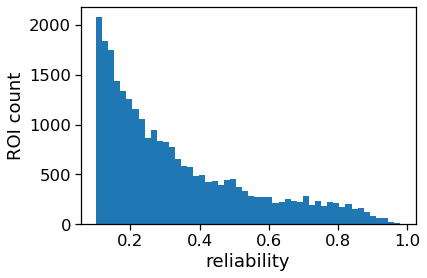

In [18]:
plt.hist(reliable.reliability, bins=50)
plt.xlabel('reliability')
plt.ylabel('ROI count')

### get responsive cells

Use threshold for prefered image trials that was used in eLife paper and Visual Coding platform: 
* For a cell to be designated as responsive, cell must have at lest 25% of trials (typically focusing on preferred image trials) where the mean response was significantly greater than the gray screen periods

In [19]:
responsive = metrics_df[metrics_df.fraction_significant_p_value_gray_screen>0.25]

C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\numpy\lib\histograms.py:829: RuntimeWarning:

invalid value encountered in greater_equal

C:\Users\marinag\Anaconda3\envs\visual_behavior_sdk\lib\site-packages\numpy\lib\histograms.py:830: RuntimeWarning:

invalid value encountered in less_equal



Text(0, 0.5, 'ROI count')

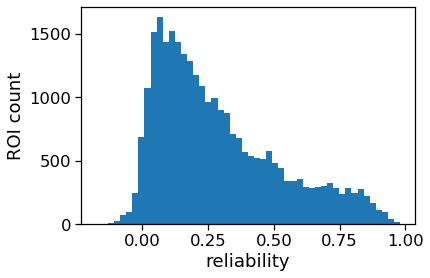

In [24]:
# look at reliability of responsive cells
plt.hist(responsive.reliability, bins=50)
plt.xlabel('reliability')
plt.ylabel('ROI count')

### merge with GLM dropouts 

In [20]:
import visual_behavior_glm.GLM_analysis_tools as gat
from visual_behavior_glm import GLM_visualization_tools as gvt
from visual_behavior_glm.glm import GLM

In [21]:
model_output_types = ['absolute_change_from_full', 'adj_fraction_change_from_full']
model_output_type = model_output_types[1]
kind = 'events' # or 'dff'
glm_version = '12_{}_L2_optimize_by_session'.format(kind)

colors = gvt.project_colors()

In [22]:
%%time
glm = gat.build_pivoted_results_summary(value_to_use=model_output_type, results_summary=None, 
                                       glm_version=glm_version, cutoff=0)
glm = glm.sort_values('date_of_acquisition')

glm = glm[(glm.project_code == 'VisualBehavior') |
                     (glm.project_code == 'VisualBehaviorTask1B') |
                     (glm.project_code =='VisualBehaviorMultiscope')].copy()
glm.cre_line.value_counts(normalize=False)

Wall time: 2min 36s


Slc17a7-IRES2-Cre    56318
Vip-IRES-Cre          7241
Sst-IRES-Cre          2666
Name: cre_line, dtype: int64

In [23]:
glm.keys()

Index(['identifier', 'Full', 'all-images', 'beh_model', 'behavioral',
       'cognitive', 'correct_rejects', 'expectation', 'face_motion_PC_0',
       'face_motion_PC_1',
       ...
       'isi_experiment_id', 'imaging_depth', 'targeted_structure',
       'published_at', 'date_of_acquisition', 'session_type', 'session_tags',
       'failure_tags', 'model_outputs_available', 'location'],
      dtype='object', length=116)

In [25]:
glm[['cell_specimen_id', 'ophys_experiment_id', 'Full']]

,cell_specimen_id,ophys_experiment_id,Full
7289,1086489529,775614751,0.0
7354,1086490469,775614751,0.0
7353,1086490415,775614751,0.0
7352,1086490386,775614751,0.0
7351,1086490371,775614751,0.0
...,...,...,...
7268,1086630685,1071440875,0.0
7267,1086630543,1071440875,0.0
7266,1086630477,1071440875,0.0
7277,1086631567,1071440875,0.0


#### Why is "Full" all zeroes? 

In [33]:
glm_metrics = metrics_df.merge(glm[['cell_specimen_id', 'ophys_experiment_id', 'Full', 'all-images', 'behavioral']], 
                               on=['cell_specimen_id', 'ophys_experiment_id'])

In [34]:
glm_metrics.keys()

Index(['cell_specimen_id', 'pref_image', 'non_pref_image', 'mean_response',
       'image_selectivity_index', 'image_selectivity_index_one_vs_all',
       'lifetime_sparseness', 'fraction_significant_p_value_gray_screen',
       'reliability', 'running_modulation_index', 'hit_miss_index',
       'ophys_experiment_id', 'ophys_session_id', 'condition',
       'session_subset', 'stimuli', 'events', 'equipment_name', 'donor_id',
       'full_genotype', 'mouse_id', 'reporter_line', 'driver_line', 'sex',
       'age_in_days', 'foraging_id', 'cre_line', 'indicator', 'session_number',
       'prior_exposures_to_session_type', 'prior_exposures_to_image_set',
       'prior_exposures_to_omissions', 'behavior_session_id',
       'ophys_container_id', 'project_code', 'container_workflow_state',
       'experiment_workflow_state', 'session_name', 'isi_experiment_id',
       'imaging_depth', 'targeted_structure', 'published_at',
       'date_of_acquisition', 'session_type', 'session_tags', 'failure_t

#### all images coding vs. reliability of change response

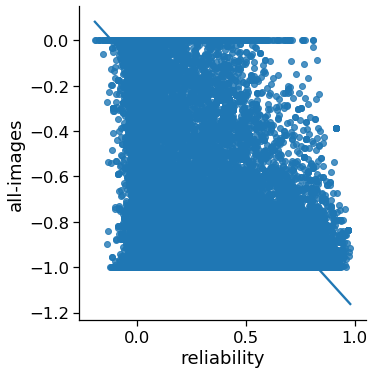

In [42]:
sns.lmplot(data=glm_metrics, x='reliability', y='all-images')